<a href="https://colab.research.google.com/github/julhamarcolan/rmn_pulse_spectrum_analysis/blob/main/binomial_pulse_spectrum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Composite pulses are pulses composed of sub-pulses. They are generally used when there is no need for spatial encoding.
In imaging, one common application is fat suppression, where binomial pulses are typically employed.

# Binomial Pulses
## Definition
- Binomial expansion:
  $$
  (a+b)^m = q_{m,0}a^m + q_{m,1}a^{m-1}b + \ldots + q_{m,m}b^m
  $$

- Binomial coefficients:
  $$
  q_{m,n} = \frac{m!}{(m-n)! \, n!}
  $$

---

## Frequency Response
- The frequency response of a binomial pulse is:
  $$
  S_n(f) = \cos^n(\pi f \tau)
  $$
  where:  
  - $f$: frequency offset from resonance  
  - $\tau$: time interval between sub-pulses  
  - $n$: pulse order  

- Rewritten in exponential form:
  $$
  \cos(\pi f \tau) = \frac{e^{i\pi f \tau} + e^{-i\pi f \tau}}{2}
  $$

- Therefore:
  $$
  S_n(f) = \left(\frac{e^{i\pi f \tau} + e^{-i\pi f \tau}}{2}\right)^n
  $$

- In the time domain, this corresponds to a **sum of Dirac deltas** spaced by $\tau$, weighted by the binomial coefficients.

---
## Zeros and Selectivity
- $S_n(f)$ exhibits **periodic zeros** at:
  $$
  f = \frac{(2k+1)}{2\tau}, \quad k \in \mathbb{Z}
  $$

- These zeros can be used to **selectively suppress** spectral components (water or fat).

---
## Application: Fat Suppression
- Water–fat frequency difference:
  $$
  \Delta f \approx 3.5 \, \text{ppm}
  $$

  - At $1.5 \, \text{T}$ → $\Delta f \approx 220 \, \text{Hz}$  
  - At $3 \, \text{T}$ → $\Delta f \approx 440 \, \text{Hz}$

- Suppression condition:
  $$
  \tau = \frac{1}{2\Delta f}
  $$

- Example:  
  - At $1.5 \, \text{T}$ → $\tau \approx 2.27 \, \text{ms}$  
  - At $3 \, \text{T}$ → $\tau \approx 1.14 \, \text{ms}$
---

## Notes
- Both water and fat generate $^{1}H$ signal, but with a **different chemical shift**.  
- The binomial pulse creates a spectral profile in which one component can be nulled.  
- Fat suppression is the most common application, as lipid signal can mask the water signal.  
- Higher pulse orders ($n$) improve selectivity but increase pulse duration and sensitivity to field inhomogeneities.  


In [21]:
import numpy as np
from scipy.special import comb
import matplotlib.pyplot as plt

In [25]:
def binomial_pulse(n, tau_ms):
    """
    Generate a discrete binomial pulse.

    Args:
        n (int): Order of the binomial pulse (n ≥ 0).
        tau_ms (float): Time interval between consecutive subpulses [ms].

    Returns:
        t_ms (np.ndarray): Array of time instants [ms] where each subpulse occurs.
        q (np.ndarray): Relative amplitudes of the subpulses (binomial coefficients).
    """
    q = np.array([comb(n, k) for k in range(n+1)])
    t_ms = np.array([k * tau_ms for k in range(n+1)])
    return t_ms, q


In [26]:
def pulse_fourier(t_ms, q, f_Hz):
    """
    Compute the Fourier transform of a discrete binomial pulse.

    Args:
        t_ms (np.ndarray): Array of time instants [ms] where subpulses occur.
        q (np.ndarray): Relative amplitudes of the subpulses (binomial coefficients).
        f_Hz (np.ndarray): Frequency array [Hz] at which to evaluate the transform.

    Returns:
        S_f (np.ndarray): Complex values of the Fourier transform of the pulse at f_Hz.
    """
    t_s = t_ms * 1e-3  # Convert time to seconds
    S_f = np.zeros_like(f_Hz, dtype=complex)
    for k in range(len(t_s)):
        S_f += q[k] * np.exp(-2j * np.pi * f_Hz * t_s[k])
    return S_f


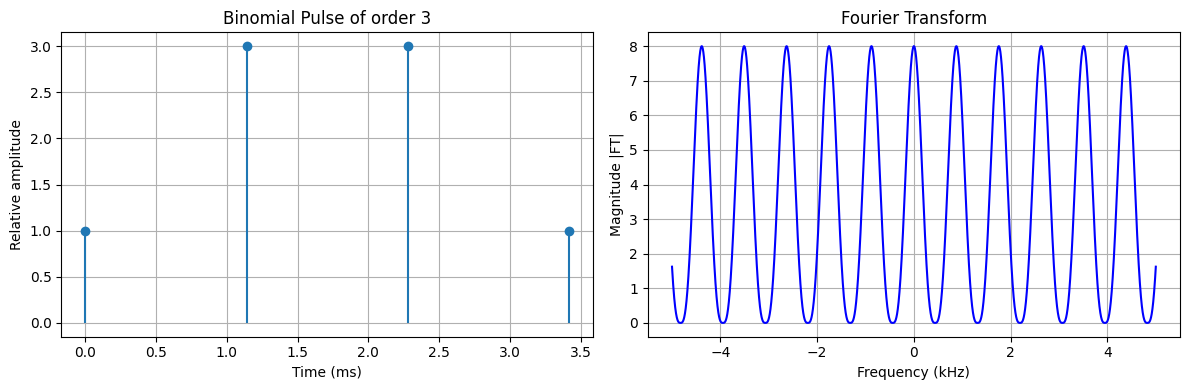

In [27]:

n = 3             # Order of the binomial pulse
tau_ms = 1.14     # Interval between subpulses [ms]
f_Hz = np.linspace(-5000, 5000, 20000)  # Frequency axis [Hz]

# Generate pulse and spectrum
t_ms, q = binomial_pulse(n, tau_ms)
S_f = pulse_fourier(t_ms, q, f_Hz)

fig, axs = plt.subplots(1, 2, figsize=(12,4))

# Time-domain pulse
axs[0].stem(t_ms, q, basefmt=" ")
axs[0].set_xlabel("Time (ms)")
axs[0].set_ylabel("Relative amplitude")
axs[0].set_title(f"Binomial Pulse of order {n}")
axs[0].grid(True)

# Fourier transform
axs[1].plot(f_Hz/1e3, np.abs(S_f), 'b')
axs[1].set_xlabel("Frequency (kHz)")
axs[1].set_ylabel("Magnitude |FT|")
axs[1].set_title("Fourier Transform")
axs[1].grid(True)

plt.tight_layout()
plt.show()

# Binomial Pulses: Ideal vs. Practical Case

In theory, we use **Dirac deltas** (zero duration in time) to derive the frequency response of binomial pulses:

$$
S_n(f) = \cos^n(\pi f \tau)
$$

However, in practice, each delta is replaced by a **rectangular pulse of finite duration** (*hard pulse*).  
This introduces some important consequences:

---

## 1. Spectral Convolution

The ideal spectrum of binomial pulses (derived from deltas) is **convolved** with the Fourier transform of a rectangular pulse.  

Since the Fourier transform of a rectangle is a sinc function:

$$
\text{FT}\{\text{rect}(t)\} = \tau_p \, \text{sinc}(f \, \tau_p)
$$

where $\tau_p$ is the duration of the sub-pulse.

---

## 2. Effect on the Frequency Profile

- The **main zeros** of $S_n(f)$ remain in the same position (determined by $\tau$).  
- The edges become **smoothed**.  
- A **sinc envelope** appears, modulating the entire response.  
- Selectivity is slightly reduced, since the transition between pass band and suppressed band becomes less sharp.  


In [17]:
def fourier_transform(signal, dt_ms):
    """
    Compute the Fourier transform of a signal.

    Args:
        signal (np.ndarray): Input signal in time domain.
        dt_ms (float): Time step [ms].

    Returns:
        freq_kHz (np.ndarray): Frequency vector [kHz].
        spectrum (np.ndarray): Complex Fourier spectrum (fftshift applied).
    """

    N = len(signal)
    freq_per_ms = np.fft.fftfreq(N, dt_ms)   # units: 1/ms
    spectrum = np.fft.fftshift(np.fft.fft(signal))
    freq_per_ms = np.fft.fftshift(freq_per_ms)
    return freq_per_ms, spectrum


In [15]:
def hard_binomial_pulse(n, tau_ms, pw_ms, dt_ms=0.001):
    """
    Compute the Fourier transform of a time-domain signal using FFT.

    Args:
        signal (np.ndarray): Input signal in the time domain.
        dt_ms (float): Sampling interval in milliseconds.

    Returns:
        freq_kHz (np.ndarray): Frequency vector in kilohertz (kHz), with fftshift applied.
        spectrum (np.ndarray): Complex Fourier spectrum of the signal (fftshift applied).
    """
    # Convert everything to seconds for internal calculations
    tau = tau_ms * 1e-3
    pw = pw_ms * 1e-3
    dt = dt_ms * 1e-3

    # Normalized binomial coefficients
    coeffs = np.array([comb(n, k) for k in range(n+1)], dtype=float)
    coeffs = coeffs / np.sum(coeffs)

    # Total pulse duration
    t_max = n * tau + 2 * pw
    t = np.arange(0, t_max, dt)
    signal = np.zeros_like(t)

    # Construct each rectangular subpulse scaled by the binomial coefficients
    for i, c in enumerate(coeffs):
        start = int((i * tau) / dt)
        end = start + int(pw / dt)
        signal[start:end] += c

    # Return time in milliseconds
    return t * 1e3, signal

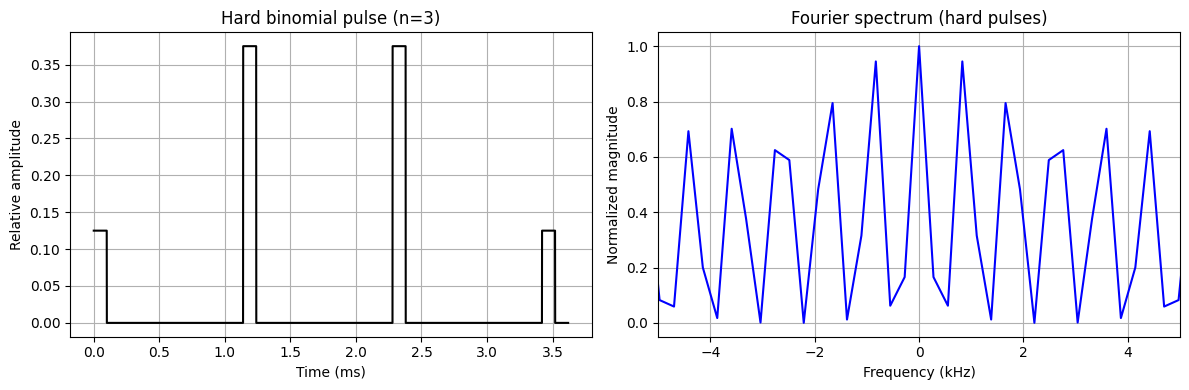

In [18]:
# Parameters (all in ms)
n = 3          # Order of the binomial pulse
tau_ms = 1.14  # Spacing between subpulses (ms)
pw_ms = 0.1    # Duration of each hard pulse (ms)
dt_ms = 0.001  # Temporal resolution (ms) = 1 µs

# Generate pulse and spectrum
t_ms, signal = hard_binomial_pulse(n, tau_ms, pw_ms, dt_ms)
f_kHz, S = fourier_transform(signal, dt_ms)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Time-domain pulse
axs[0].plot(t_ms, signal, 'k')
axs[0].set_xlabel("Time (ms)")
axs[0].set_ylabel("Relative amplitude")
axs[0].set_title(f"Hard binomial pulse (n={n})")
axs[0].grid(True)

# Frequency-domain spectrum
axs[1].plot(f_kHz, np.abs(S)/np.max(np.abs(S)), 'b')
axs[1].set_xlim(-5, 5)  # Zoom into ±5 kHz
axs[1].set_xlabel("Frequency (kHz)")
axs[1].set_ylabel("Normalized magnitude")
axs[1].set_title("Fourier spectrum (hard pulses)")
axs[1].grid(True)

plt.tight_layout()
plt.show()